# A1

In [1]:
# Standard imports
import numpy as np
import math
import matplotlib.pylab as plt
%matplotlib inline
from scipy import integrate
import a1_solutions

## Some supplied helper functions

In [2]:
def PlotSpikeRaster(st, y_range=[0, 1.]):
    '''
    PlotSpikeRaster(spiketimes, y_range=[0, 1.])

    Plots a spike raster plot for a list of arrays of spike times.

    Input:
      spiketimes is a list of arrays of spike times, like that returned
          by the function Stim2Spikes.
      y_range is a 2-tuple that holds the y-values that the raster ticks
          should be drawn between
    '''
    N = len(st)  # number of neurons

    #levels = np.linspace(y_range[0], y_range[1], N+1, endpoint=True)
    levels = np.linspace(y_range[1], y_range[0], N+1, endpoint=True)
    for n in range(N):
        nspikes = len(st[n])
        #y = [ [levels[n]]*nspikes , [levels[n+1]]*nspikes ]
        y = [ [levels[n+1]]*nspikes , [levels[n]]*nspikes ]
        #y = y_range[0] + [levels[n]]*nspikes
        plt.plot(np.vstack((st[n],st[n])), y, color=np.random.rand(3))
    plt.ylim(y_range)
    plt.xlabel('Time (s)')
    return


def GenerateSpikeTrain(rates, T, jitter=0.):
    '''
    spike_times = GenerateSpikeTrain(rates, T)
    
    Creates a spike train (as an array of time stamps).
    
    Input:
    rates is an array or list of firing rates (in Hz), one
        firing rate for each interval.
    T is an array or list (the same size as 'rates') that gives
        the time to end each interval
    jitter is a scalar that determines how much the spikes
        are randomly moved
        
    Output:
    spike_times is an array of times when spikes occurred
    
    Example: To create a spike train of 10Hz for 0.5s, followed
             by 25Hz that starts at 0.5s and ends at 2s, use
             
               GenerateSpikeTrain([10, 25], [0.5, 2])
    '''
    s = []
    t = 0.
    for idx in range(0,len(rates)):
        Trange = T[idx] - t
        if rates[idx]!=0:
            delta = 1. / rates[idx]
            N = rates[idx] * Trange
            times = np.arange(t+delta/2., T[idx], delta)
            times += np.random.normal(scale=delta*jitter, size=np.shape(times))
            s.extend(times)
        t = T[idx]
    s.sort()
    return np.array(s)


class InputNeuron(object):
    
    def __init__(self, spiketrain):
        '''
        InputNeuron(spiketrain)
        
        Constructor for InputNeuron class.
        
        InputNeuron is a class of neuron that can be used to inject spikes into
        the network. When involved in a simulation, an InputNeuron will generate
        spikes at the times specified during its construction.
        
        Inputs:
         spiketrain is an array or list of spike times
        '''
        self.spikes = np.array(spiketrain)

    def SpikesBetween(self, t_start, t_end):
        '''
        numspikes = InputNeuron.SpikesBetween(t_start, t_end)
        
        Returns the number of times the neuron spiked between t_start and t_end.
        Specifically, it counts a spike if it occurred at t, where
        t_start <= t < t_end
        '''
        sp_bool = np.logical_and( np.array(self.spikes)>=t_start, np.array(self.spikes)<t_end )
        return np.sum(sp_bool)
    
    def Slope(self):
        return
    
    def Step(self, t, dt):
        return

# Q1: LIFNeuron Class

## LIFNeuron class

In [3]:
class LIFNeuron(object):

    def __init__(self, tau_m=0.02, tau_ref=0.002, tau_s=0.05):
        '''
        LIFNeuron(tau_m=0.02, tau_ref=0.002, tau_s=0.05)
        
        Constructor for LIFNeuron class
        
        Inputs:
         tau_m   membrane time constant, in seconds (s)
         tau_ref refractory period (s)
         tau_s   synaptic time constant (s)
        '''
        self.tau_m = tau_m      # membrane time constant
        self.tau_ref = tau_ref  # refractory period
        self.tau_s = tau_s      # synaptic time constant
        self.v = 0.             # sub-threshold membrane potential (voltage)
        self.s = 0.             # post-synaptic current (PSC)
        self.dvdt = 0.          # slope of v (w.r.t. time)
        self.dsdt = 0.          # slope of s (w.r.t. time)
        
        self.weighted_incoming_spikes = 0.  # weighted sum of incoming spikes (for one time step)
        self.ref_remaining = 0. # amount of time remaining in the refractory period
        
        # For plotting
        self.v_history = []     # records v over time
        self.spikes = []        # list of times when this neuron spiked
        

    def SpikesBetween(self, t_start, t_end):
        '''
        numspikes = LIFNeuron.SpikesBetween(t_start, t_end)
        
        Returns the number of times the neuron spiked between t_start and t_end.
        Specifically, it counts a spike if it occurred at t, where
        t_start <= t < t_end
        '''
        sp_bool = np.logical_and( np.array(self.spikes)>=t_start, np.array(self.spikes)<t_end )
        return np.sum(sp_bool)
    
    
    def Slope(self):
        '''
        LIFNeuron.Slope()
        
        Evaluates the right-hand side of the differential equations that
        govern v and s. The slopes get stored in the internal variables
          self.dvdt, and
          self.dsdt
        '''
        #==== REPLACE THE CODE BELOW ====
        self.dvdt = (self.s - self.v) / self.tau_m
        self.dsdt = - self.s / self.tau_s
        
        
    def Step(self, t, dt):
        '''
        LIFNeuron.Step(t, dt)
        
        Updates the LIF neuron state by taking an Euler step in v and s.
        If v reaches the threshold of 1, the neuron fires an action potential
        (spike). The spike time is appended to the list self.spikes, and v
        is set to zero. After a spike, the neuron is dormant for self.tau_ref
        seconds.
        
        If a spike occurs part-way through a time step, linear interpolation
        is used to estimate the time that v hit the threshold of 1.
        '''
        
        #==== PLACE YOUR CODE HERE ====
        if self.ref_remaining > 0:
            self.ref_remaining -= dt
        else:
            self.Slope()
            old_v = self.v  
            self.v += dt * self.dvdt
            self.s += dt * self.dsdt
            self.s += self.weighted_incoming_spikes / self.tau_s
            if self.v >= 1:
                spike_time = np.interp(1, [old_v, self.v], [t, t+dt])
                self.spikes.append(spike_time)
                self.v = 0
                self.ref_remaining = self.tau_ref
            
        # Store v (for plotting), and reset incoming spike accumulator
        self.v_history.append(self.v)
        self.weighted_incoming_spikes = 0.
        
    def ReceiveSpike(self, w):
        '''
        LIFNeuron.ReceiveSpike(w)
        
        Registers the arrival of a spike from a presynaptic neuron. The
        member variable self.weighted_incoming_spikes keeps track of all
        the incoming spikes, each weighted by their respective connection
        weights. It is sufficient to add them all together to tabulate the
        total incoming weighted spikes (from all presynaptic neurons).
        
        Input:
         w    is the connection weight from the presynaptic neuron.
        '''
        self.weighted_incoming_spikes += w  # [1]
        

# Q2: SpikingNetwork Class

## SpikingNetwork Class

In [4]:
class SpikingNetwork(object):
    
    def __init__(self):
        '''
        SpikingNetwork()
        
        Constructor for SpikingNetwork class.
        
        The SpikingNetwork class contains a collection of neurons,
        and the connections between those neurons.
        '''
        self.neurons = []      # List of neurons (of various kinds)
        self.connections = []  # List of connections
        self.t_history = []    # List of time stamps for the Euler steps
                               # (Useful for plotting)
        
        
    def AddNeuron(self, neur):
        '''
        SpikingNetwork.AddNeuron(neuron)
        
        Adds a neuron to the network.
        
        Input:
         neuron is an object of type LIFNeuron or InputNeuron
        '''
        self.neurons.append(neur)

        
    def Connect(self, pre, post, w):
        '''
        SpikingNetwork.Connect(pre, post, w)
        
        Connects neuron 'pre' to neuron 'post' with a connection
        weigth of w.
        
        Each "connection" is a list of 3 numbers of the form:
         [ pre_idx, post_idx, weight ]
        where
         pre_idx is the list index of the pre-synaptic neuron,
         post_idx is the list index of the post-synaptic neuron, and
         weight is the connection weight.
        eg. self.connections = [[0,1,0.05], [1,2,0.04], [1,0,-0.2]]
        '''
        self.connections.append([pre, post, w])
     
    
    def Simulate(self, T, dt=0.001):
        '''
        SpikingNetwork.Simulate(T, dt=0.001)
        
        Simulates the network for T seconds by taking Euler steps
        of size dt.
        
        Inputs:
         T    how long to integrate for
         dt   time step for Euler's method
        '''
        # This code takes care of recording time samples in a way
        # that allows continuation. You needn't fuss over this code.
        current = 0 if len(self.t_history)==0 else self.t_history[-1]
        t_segment = np.arange(current, current+T, dt)
        
        #==== HERE IS WHERE YOUR CODE STARTS ====
        
        # Loop over time steps (I've set that up for you)
        for tt in t_segment:
            self.t_history.append(tt)  # Record time stamp
            
            
        #==== PLACE YOUR CODE HERE ====
            # Update and tabulate spikes for each neuron
            for i, neuron in enumerate(self.neurons):
                neuron.Step(tt, dt)
                # If neuron spiked, push spikes downstream for post-synaptic neurons 
                # i.e., neurons that have connections to n, for the next time step.
                num_of_spikes = neuron.SpikesBetween(tt, tt+dt)  
                for connection in self.connections:
                    pre_idx, post_idx, weight = connection
                    if i == pre_idx:
                        post_syn_neuron = self.neurons[post_idx]
                        post_syn_neuron.ReceiveSpike(num_of_spikes * weight)
                                                    
    def AllSpikeTimes(self):
        '''
        SpikingNetwork.AllSpikeTimes()
        
        Returns all the spikes of all the neurons in the network.
        Useful for making spike-raster plots of network activity.
        
        Output:
         all_spikes  a list of sublists, where each sublist holds
                     the spike times of one of the neurons
        '''
        blah = []
        for neur in self.neurons:
            blah.append(np.array(neur.spikes))
        return blah

# Q3: Experiments with Spiking Networks

## (a) One LIF Neuron

In [5]:
net = SpikingNetwork()
#net = a1_solutions.SpikingNetwork()
net.AddNeuron(LIFNeuron(tau_s=0.1))  # Neuron 0
net.AddNeuron(InputNeuron( GenerateSpikeTrain([30], [1]) ))  # Neuron 1
net.Connect(1, 0, 0.05)  # Connect from neuron 1 to neuron 0

net.Simulate(1, 0.001)

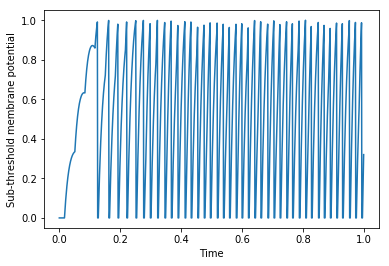

In [6]:
# i.
LIF_neuron = net.neurons[0]
t = net.t_history
v = LIF_neuron.v_history
plt.plot(t, v)
plt.xlabel("Time")
plt.ylabel("Sub-threshold membrane potential")
plt.show()

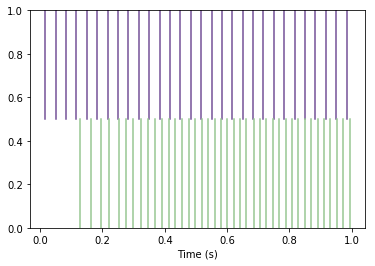

In [7]:
# ii.
Input_neuron = net.neurons[1]
st = [Input_neuron.spikes, LIF_neuron.spikes]
PlotSpikeRaster(st)

## (b) LIF Firing Rate Curve

In [8]:
# i.
net = SpikingNetwork()
#net = a1_solutions.SpikingNetwork()
net.AddNeuron(LIFNeuron(tau_s=0.1))  # Neuron 0
rates = np.arange(5, 101, 5)
T = np.arange(2, 41, 2)
simulation_time = len(T) * 2
net.AddNeuron(InputNeuron(GenerateSpikeTrain(rates, T)))  # Neuron 1
net.Connect(1, 0, 0.03)  # Connect from neuron 1 to neuron 0

net.Simulate(simulation_time, 0.001)

In [9]:
# ii.
num_intervals = len(T)
spikes_count = np.zeros(num_intervals)
LIF_neuron = net.neurons[0]
for i in range(0, num_intervals):
    start_time = 2 * i
    end_time = 2 * i + 2
    spikes_count[i] = LIF_neuron.SpikesBetween(start_time, end_time)
print(spikes_count)

[  0.   0.   0.   0.   0.   0.  30.  55.  74.  89. 108. 120. 130. 139.
 151. 146. 170. 180. 191. 200.]


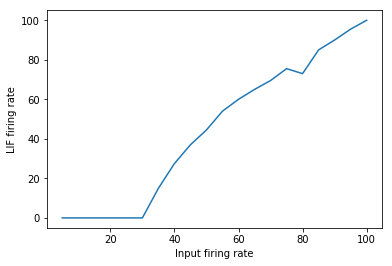

In [10]:
# iii.
LIF_firing_rates = spikes_count / 2.0
plt.plot(rates, LIF_firing_rates)
plt.xlabel("Input firing rate")
plt.ylabel("LIF firing rate")
plt.show()

## (c) Two LIF Neurons

In [11]:
# i.
net = SpikingNetwork()
#net = a1_solutions.SpikingNetwork()
net.AddNeuron(LIFNeuron())  # Neuron 0 (A)
net.AddNeuron(LIFNeuron())  # Neuron 1 (B)
net.AddNeuron(InputNeuron(GenerateSpikeTrain([30], [0.3])))  # Neuron 2
net.Connect(0, 1, 0.05)  # Connect from neuron 0 to neuron 1
net.Connect(1, 0, 0.05)  # Connect from neuron 1 to neuron 0
net.Connect(2, 0, 0.05)  # Connect from neuron 2 to neuron 0

net.Simulate(1, 0.001)

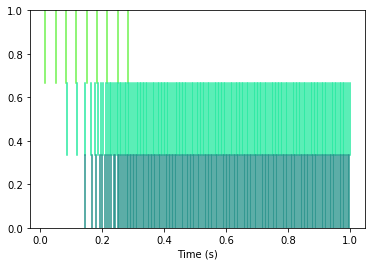

In [12]:
# ii.
A_neuron = net.neurons[0]
B_neuron = net.neurons[1]
Input_neuron = net.neurons[2]
st = [Input_neuron.spikes, A_neuron.spikes, B_neuron.spikes]
PlotSpikeRaster(st)

## (d) Three LIF Neurons: Inhibition

In [13]:
# i.
net = SpikingNetwork()
#net = a1_solutions.SpikingNetwork()
net.AddNeuron(LIFNeuron())  # Neuron 0 (A)
net.AddNeuron(LIFNeuron())  # Neuron 1 (B)
net.AddNeuron(LIFNeuron())  # Neuron 2 (C)
net.AddNeuron(InputNeuron(GenerateSpikeTrain([30], [0.3])))  # Neuron 3
net.AddNeuron(InputNeuron(GenerateSpikeTrain([0, 50], [0.7, 1.]))) # Neuron 4
net.Connect(0, 1, 0.05)  # Connect from neuron 0 to neuron 1
net.Connect(1, 0, 0.05)  # Connect from neuron 1 to neuron 0
net.Connect(2, 1, -0.2)  # Connect from neuron 2 to neuron 1

net.Connect(3, 0, 0.05)  # Connect from neuron 3 to neuron 0
net.Connect(4, 2, 0.05)  # Connect from neuron 4 to neuron 2

net.Simulate(1.5, 0.001)

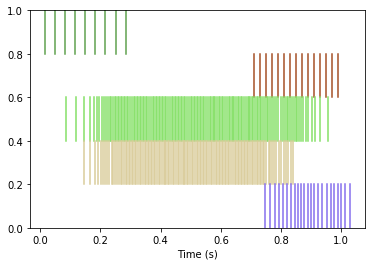

In [14]:
# ii.
A_neuron = net.neurons[0]
B_neuron = net.neurons[1]
C_neuron = net.neurons[2]
Input_A_neuron = net.neurons[3]
Input_C_neuron = net.neurons[4]
st = [Input_A_neuron.spikes, Input_C_neuron.spikes, A_neuron.spikes, B_neuron.spikes, C_neuron.spikes]
PlotSpikeRaster(st)

### iii.

The addition of neuron C and its negative connection inhibits neuron A and neuron B from firing. From time = 0.7, neuron C is activated, and it immediately starts to decrease the firing rate of neuron B. Later, since neuron B's firing rate has decreased, neuron A and B are connected to each other, neuron A's firing rate also starts to decrease. Eventally, both neuron A and neuron B are inhibited from firing.


## (e) Ring Oscillator

In [15]:
# i.
net = SpikingNetwork()
#net = a1_solutions.SpikingNetwork()

net.AddNeuron(LIFNeuron(tau_m=0.05, tau_s=0.1))  # Neuron 0 (A)
net.AddNeuron(LIFNeuron(tau_m=0.05, tau_s=0.1))  # Neuron 1 (B)
net.AddNeuron(LIFNeuron(tau_m=0.05, tau_s=0.1))  # Neuron 2 (C)
net.AddNeuron(LIFNeuron(tau_m=0.05, tau_s=0.1))  # Neuron 3 (D)
net.AddNeuron(LIFNeuron(tau_m=0.05, tau_s=0.1))  # Neuron 4 (E)
net.AddNeuron(LIFNeuron(tau_m=0.05, tau_s=0.1))  # Neuron 5 (F)
net.AddNeuron(LIFNeuron(tau_m=0.05, tau_s=0.1))  # Neuron 6 (G)
net.AddNeuron(LIFNeuron(tau_m=0.05, tau_s=0.1))  # Neuron 7 (H)

net.Connect(0, 1, 0.2)  # Connect from neuron 0 to neuron 1
net.Connect(1, 2, 0.2)  # Connect from neuron 1 to neuron 2
net.Connect(2, 3, 0.2)  # Connect from neuron 2 to neuron 3
net.Connect(3, 4, 0.2)  # Connect from neuron 3 to neuron 4
net.Connect(4, 5, 0.2)  # Connect from neuron 4 to neuron 5
net.Connect(5, 6, 0.2)  # Connect from neuron 5 to neuron 6
net.Connect(6, 7, 0.2)  # Connect from neuron 6 to neuron 7
net.Connect(7, 0, 0.2)  # Connect from neuron 7 to neuron 0






In [16]:
# ii.
net.Connect(1, 0, -0.4)  # Connect from neuron 1 to neuron 0
net.Connect(2, 1, -0.4)  # Connect from neuron 2 to neuron 1
net.Connect(3, 2, -0.4)  # Connect from neuron 3 to neuron 2
net.Connect(4, 3, -0.4)  # Connect from neuron 4 to neuron 3
net.Connect(5, 4, -0.4)  # Connect from neuron 5 to neuron 4
net.Connect(6, 5, -0.4)  # Connect from neuron 6 to neuron 5
net.Connect(7, 6, -0.4)  # Connect from neuron 7 to neuron 6
net.Connect(0, 7, -0.4)  # Connect from neuron 0 to neuron 7



In [17]:
# iii.
Input_neuron = InputNeuron(GenerateSpikeTrain([25], [0.3]))  # Neuron 8
net.AddNeuron(Input_neuron)
net.Connect(8, 0, 0.2)  # Connect from neuron 8 to neuron 0

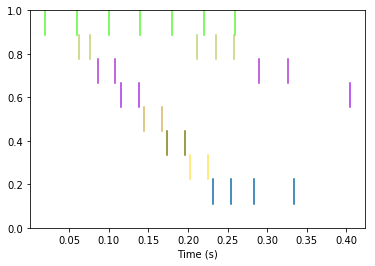

In [18]:
# iv.
net.Simulate(4, 0.001)
A, B, C, D, E, F, G, H, Input_neuron = net.neurons
st = [Input_neuron.spikes, A.spikes, B.spikes, C.spikes, D.spikes, E.spikes, F.spikes, G.spikes, H.spikes]
PlotSpikeRaster(st)

# Q4: Neural Activation Functions

## (a) ReLU derivative

$$
f(x) = \begin{cases}1, \hspace{1cm} \text{if } x > 0\\0, \hspace{1cm}\text{otherwise}\end{cases} 
$$

## (b.i) Logistic

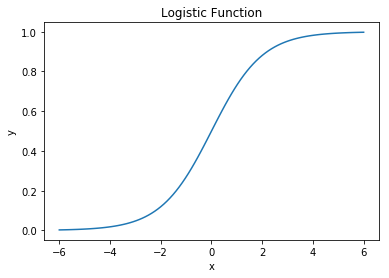

In [19]:
# i.
x = np.linspace(-6, 6, 100)
y = 1 / ( 1 + np.exp(-x))
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Logistic Function')
plt.show()

The values of the domain for which the derivative approaches or equals zero:  

When x approaches -infinity or infinity.  

The values of the domain where the gradient is maximaized:  

When x is 0.


## (b.ii) tanh

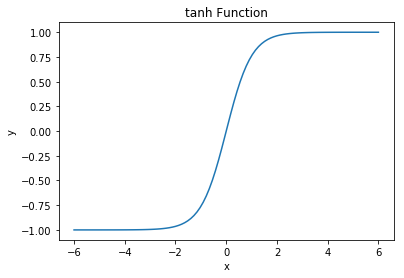

In [20]:
# ii.
x = np.linspace(-6, 6, 100)
y = np.tanh(x)
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('tanh Function')
plt.show()

The values of the domain for which the derivative approaches or equals zero:  

When x approaches -infinity or infinity.  

The values of the domain where the gradient is maximaized:  

When x is 0.


## (b.iii) ReLU

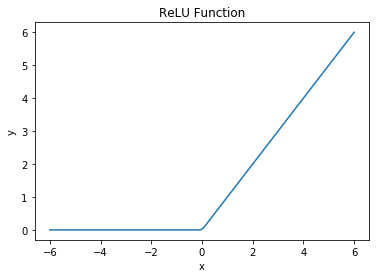

In [21]:
# iii.
x = np.linspace(-6, 6, 100)
y = x * (x > 0)
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('ReLU Function')
plt.show()

The values of the domain for which the derivative approaches or equals zero:  

When x is negative.

The values of the domain where the gradient is maximaized:  

When x is positive, the gradient is always 1.


## (c.i) Derivative of f with respect to x

Let $s = wx + b$. Then $f(wx+b) = f(s)$. Since f is differentiable, we have $\frac{df}{dx} = \frac{df}{ds} \frac{ds}{dx} = \frac{df}{ds} w.$

## (c.ii) Derivative of f with respect to W

Let $s = wx + b$. Then $f(wx+b) = f(s)$. Since f is differentiable, we have $\frac{df}{dw} = \frac{df}{ds} \frac{ds}{dw} = \frac{df}{ds} x.$

## (c.ii) Derivative of f with respect to b

Let $s = wx + b$. Then $f(wx+b) = f(s)$. Since f is differentiable, we have $\frac{df}{db} = \frac{df}{ds} \frac{ds}{db} = \frac{df}{ds}.$